In [1]:
#!/usr/bin/env python
# coding: utf-8

# Calulate ssh spectra and phase spectra at every point along the coast 
import cmocean as cmo
import numpy as np
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from netCDF4 import Dataset
from xmitgcm import open_mdsdataset
import time
import matplotlib.pyplot as plt

In [2]:
def create_nc_file(dist_array, freq_array, psd_data, phase_data, filename,
                   title, description, units1='PSD', units2='rad', 
                   name1='ssh PSD', name2='phase'):
    
    """ This function creates a netCDF4 file for
    the curtain plot data given the filename. 
    
    :arg dist_array: np 2D array, distance from bay array from meshgrid
    :arg frq_array: np 2D array, frequency array from spectra
    :arg PSD_data: np 2D array of PDS spectra of curtain data. Size is (len(dist_array),len(freq_array))
    :arg PSD_data: np 2D array of phase spectra of curtain data. Size is (len(dist_array),len(freq_array))
    :arg filename: str, Directory and name of netcdf file
    :arg title: str, title of plot
    :arg description: str, Details about the data
    :arg units1: str, Units of PSD data
    :arg units2: str, Units of phase data
    :arg name1: str, name of var 1 (PSD)
    :arg name2: str, name or var 2 (phase)
    
    """
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', dist_array.shape[0])
    file_t = dataset.createDimension('freq', freq_array.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('x'))
    file_T = dataset.createVariable('Freq', 'f8', ('freq'))
    amp_data = dataset.createVariable('psd_data', 'f8', ('x','freq'))
    pha_data = dataset.createVariable('phase_data', 'f8', ('x','freq'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'ICACC-UNAM'
    dataset.source = '/notebooks/MITgcm/domain5/spectra_curtain_data_barotropic.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Distance along the coast from SVB'
    file_X.units = 'km'
    file_T.standard_name = 'frequency'
    file_T.units = 'cpd'
    amp_data.standard_name = name1
    amp_data.units = units1
    pha_data.standard_name = name2
    pha_data.units = units2
    
    file_X[:] = dist_array[:]
    file_T[:] = freq_array[:]
    amp_data[:] = psd_data[:]
    pha_data[:] = phase_data[:]

    dataset.close()

In [3]:
## Load ssh curtain data    
SVB = xr.open_dataset('curtain_SSH_SVB_AugTS.nc')
noSVB = xr.open_dataset('curtain_SSH_NoSVB_AugTS.nc')

X = SVB.X[:] 
t = SVB.T[:] # in sec

nx = len(X[:])
ny = int(len(t[:])/2)+1

psd = np.zeros((nx,ny))*np.nan
phase = np.zeros((nx,ny))*np.nan

t0 = 0
dt = 600 # 10 min 
freq = (1./dt)

ssh_anom = (SVB.curtain_data.data-noSVB.curtain_data.data)*100 

for ii in range(nx): #nx
    signalFFT = np.fft.rfft(ssh_anom[:,ii])
    
    ## Get Power Spectral Density
    signalPSD = np.abs(signalFFT) ** 2
    #signalPSD /= len(signalFFT)**2

    ## Get Phase
    signalPhase = np.angle(signalFFT)

    ## Get frequencies corresponding to signal 
    fftFreq = np.fft.rfftfreq(len(ssh_anom[:,ii]), dt)

    psd[ii,:] = signalPSD[:]
    phase[ii,:] = signalPhase[:]

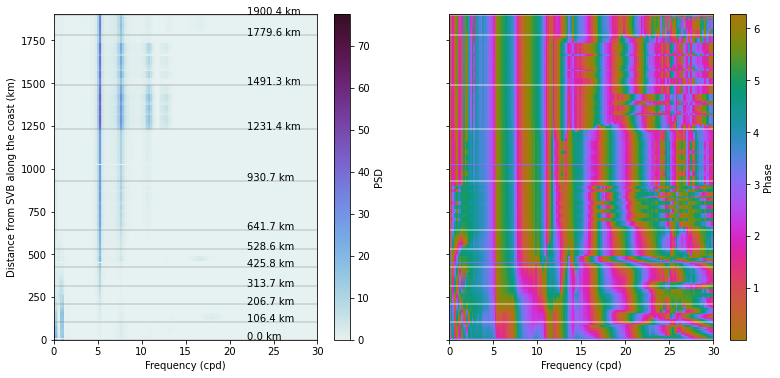

In [4]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(13,6), sharey=True, sharex=True)

ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(fftFreq*86400,X, psd, cmap=cmo.cm.dense)
plt.colorbar(pc1,ax=ax1, label='PSD')

ax2.set_xlabel('Frequency (cpd)')
pc2 = ax2.pcolormesh(fftFreq*86400,X, phase+np.pi, cmap=cmo.cm.phase)
plt.colorbar(pc2,ax=ax2, label='Phase')
ax2.set_xlim(0,30)

for kk in range(nx):
    if kk%50 == 0:
        ax1.axhline(X[kk],color='0.5',alpha=0.3)
        ax1.text(22,X[kk],'%1.1f km' %X[kk], fontsize=10)
        ax2.axhline(X[kk],color='w',alpha=0.5)
      

In [5]:
filename = 'curtain_SSH_spectra_AugTS.nc'
description = 'spectra of SSH data at points along the coast to build curtain hovmöller plot AugTS'
title = 'spectra of SSH curtain plot data AugTS SVB'

create_nc_file(X, fftFreq*86400, psd, phase+np.pi, filename,
               title, description)

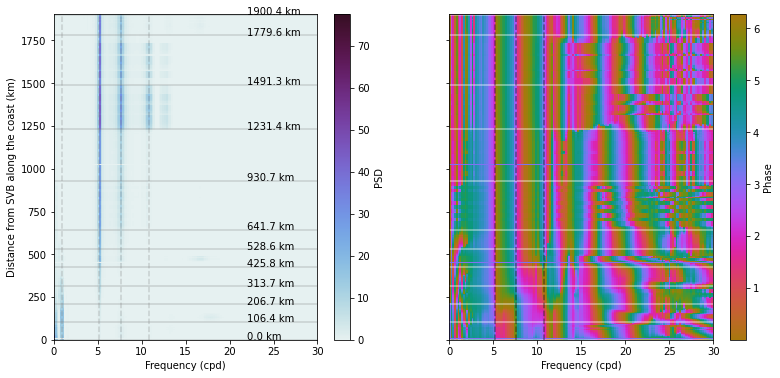

In [6]:
# Check what I saved
spec_data = xr.open_dataset('curtain_SSH_spectra_AugTS.nc')
X2 = spec_data.X
freq2 = spec_data.Freq
psd2 = spec_data.psd_data
phase2 = spec_data.phase_data

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(13,6), sharex=True, sharey=True)

ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(freq2,X2,psd2, cmap=cmo.cm.dense)
plt.colorbar(pc1,ax=ax1, label='PSD')

ax2.set_xlabel('Frequency (cpd)')
pc2 = ax2.pcolormesh(freq2,X2,phase2, cmap=cmo.cm.phase)
plt.colorbar(pc2,ax=ax2, label='Phase')
ax2.set_xlim(0,30)

for kk in range(nx):
    if kk%50 == 0:
        ax1.axhline(X[kk],color='0.5',alpha=0.3)
        ax1.text(22,X[kk],'%1.1f km' %X[kk], fontsize=10)
        ax2.axhline(X[kk],color='w',alpha=0.5)

ax1.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(1, color='0.5', linestyle='--',alpha=0.3)
ax2.axvline(5.2, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(7.6, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(10.8, color='0.1', linestyle='--',alpha=0.5)